# Comparison of Dina startup to TokaMaker (recreate EQ only w/ eddy currents)

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

In [3]:
def read_coil_currs(filename):
    with open(filename,'r') as fid:
        fid.readline()
        fid.readline()
        fid.readline()
        vals = np.array([float(val) for val in fid.readline().split()])
    return vals
def read_vv_currs(filename):
    vals = []
    with open(filename,'r') as fid:
        fid.readline()
        fid.readline()
        fid.readline()
        vals += [float(val) for val in fid.readline().split()]
        vals += [float(val) for val in fid.readline().split()]
        vals += [float(val) for val in fid.readline().split()]
    return np.array(vals)

# Inputs

In [4]:
time_pt = 4000
eqdsk = read_eqdsk('1MA_eqdsk_currs/{0:d}msec/nsf_ntt.{0:06d}'.format(time_pt))
coil_currs = read_coil_currs('1MA_eqdsk_currs/{0:d}msec/fc.txt'.format(time_pt))
vv_currs = read_vv_currs('1MA_eqdsk_currs/{0:d}msec/tcam.txt'.format(time_pt))

1.0 3.0
(37,)


In [5]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('nextstep_mesh-dina.h5')

In [6]:
mygs = TokaMaker()
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2, F0=eqdsk['rcentr']*eqdsk['bcentr']) ## F0 = B0 * R0

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tMaker_eddy_modes
Revision id:          c435b10
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.914E+00
    # of points  =    3734
    # of edges   =   11083
    # of cells   =    7350
    # of boundary points =     116
    # of boundary edges  =     116
    # of boundary cells  =     116
  Resolution statistics:
    hmin =  3.076E-03
    hrms =  4.187E-02
  

In [7]:
coil_regmat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = 1.E4*np.ones((mygs.ncoils+1,), dtype=np.float64)
coil_reg_targets = np.zeros((mygs.ncoils+1,), dtype=np.float64)

for i in range(vv_currs.shape[0]):
    coil_reg_targets[mygs.coil_sets['VV_{0}'.format(i+1)]['id']] = vv_currs[i]*1000.0
    coil_reg_weights[mygs.coil_sets['VV_{0}'.format(i+1)]['id']] = 1.E4

imap = [0,1,2,3,10,4,9,5,8,6,7,-1,-1,12,11]
for key, coil_set in mygs.coil_sets.items():
    i = coil_set['id']
    if i >= len(imap):
        break
    if imap[i] < 0:
        continue
    coil_reg_targets[i] = coil_currs[imap[i]]*1000.0
    coil_reg_weights[i] = 1.E-1

# Terms for virtual VSC coil (unused)
coil_reg_weights[-1] = 1.E4

mygs.set_coil_reg(coil_regmat,reg_weights=coil_reg_weights,reg_targets=coil_reg_targets)

In [8]:
ffprim = eqdsk['ffprim']
pprime = eqdsk['pprime']


psi_eqdsk = np.linspace(0.0,1.0,np.size(ffprim))
psi_sample = np.linspace(0.0,1.0,np.size(ffprim))

psi_prof = np.copy(psi_sample)
ffp_prof = np.transpose(np.vstack((psi_prof,np.interp(psi_sample,psi_eqdsk,ffprim)))).copy()
pp_prof = np.transpose(np.vstack((psi_prof,np.interp(psi_sample,psi_eqdsk,pprime)))).copy()

mygs.set_profiles(ffp_prof={'type': 'linterp', 'y': ffp_prof[:,1], 'x': psi_sample},pp_prof={'type': 'linterp', 'y': pp_prof[:,1], 'x': psi_sample})

In [9]:
mygs.set_targets(Ip = eqdsk['ip'], pax=eqdsk['pres'][0])

In [10]:
isoflux_pts = eqdsk['rzout'].copy()
mygs.set_isoflux(isoflux_pts)

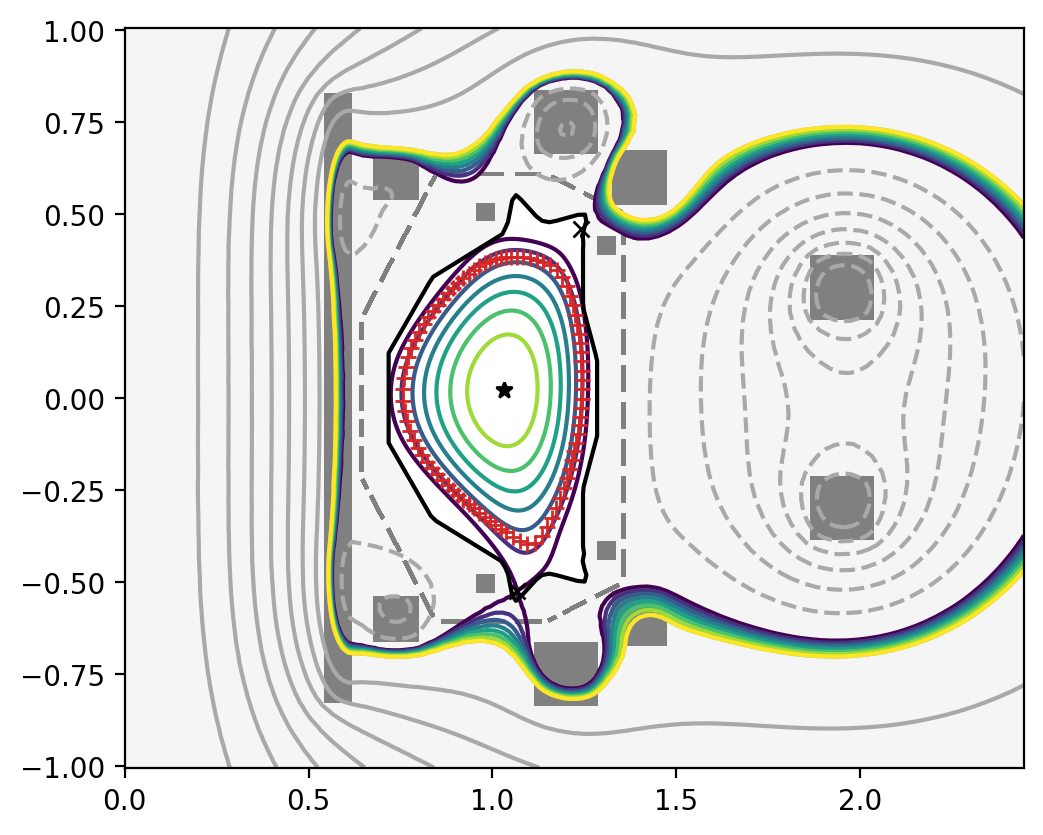

In [11]:
mygs.init_psi(1,0,0.25, 1.7,-0.5)
fig, ax = plt.subplots()
mygs.plot_psi(fig,ax)
mygs.plot_machine(fig,ax)
mygs.plot_constraints(fig,ax)

In [12]:
mygs.solve()
mygs.print_info()

Starting non-linear GS solver
     1  1.1611E+00  3.0359E-06  1.5337E-02  1.0274E+00  2.1621E-02 -0.0000E+00
     2  1.5803E+00  1.7493E-06  7.7808E-03  1.0254E+00  2.2146E-02 -0.0000E+00
     3  1.7724E+00  1.4485E-06  3.4921E-03  1.0243E+00  2.2551E-02 -0.0000E+00
     4  1.8657E+00  1.3483E-06  1.6005E-03  1.0236E+00  2.2886E-02 -0.0000E+00
     5  1.9130E+00  1.3084E-06  7.6994E-04  1.0231E+00  2.3163E-02 -0.0000E+00
     6  1.9375E+00  1.2907E-06  3.8796E-04  1.0228E+00  2.3393E-02 -0.0000E+00
     7  1.9505E+00  1.2822E-06  2.0373E-04  1.0226E+00  2.3577E-02 -0.0000E+00
     8  1.9576E+00  1.2779E-06  1.1154E-04  1.0225E+00  2.3723E-02 -0.0000E+00
     9  1.9615E+00  1.2757E-06  6.3888E-05  1.0224E+00  2.3836E-02 -0.0000E+00
    10  1.9638E+00  1.2745E-06  3.8387E-05  1.0224E+00  2.3924E-02 -0.0000E+00
    11  1.9651E+00  1.2739E-06  2.4211E-05  1.0224E+00  2.3990E-02 -0.0000E+00
    12  1.9659E+00  1.2735E-06  1.5956E-05  1.0223E+00  2.4041E-02 -0.0000E+00
    13  1.9665E+00  1.

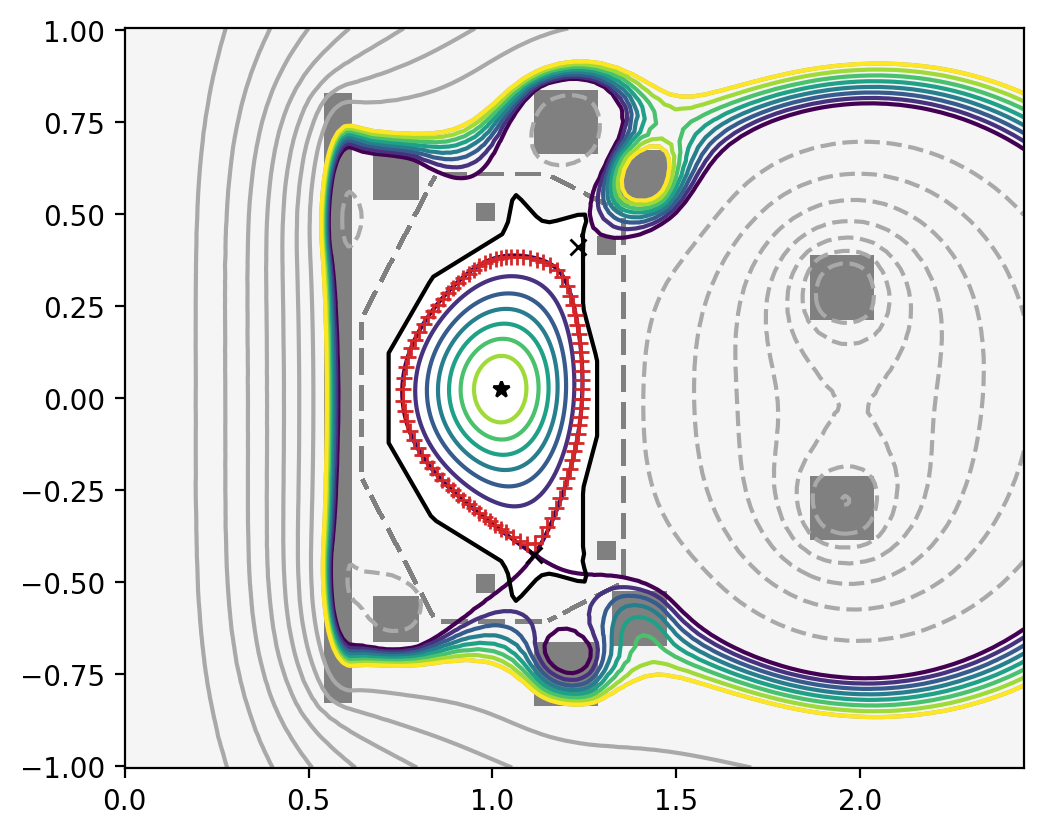

In [13]:
fig, ax = plt.subplots()
mygs.plot_psi(fig,ax)
mygs.plot_machine(fig,ax)
mygs.plot_constraints(fig,ax)

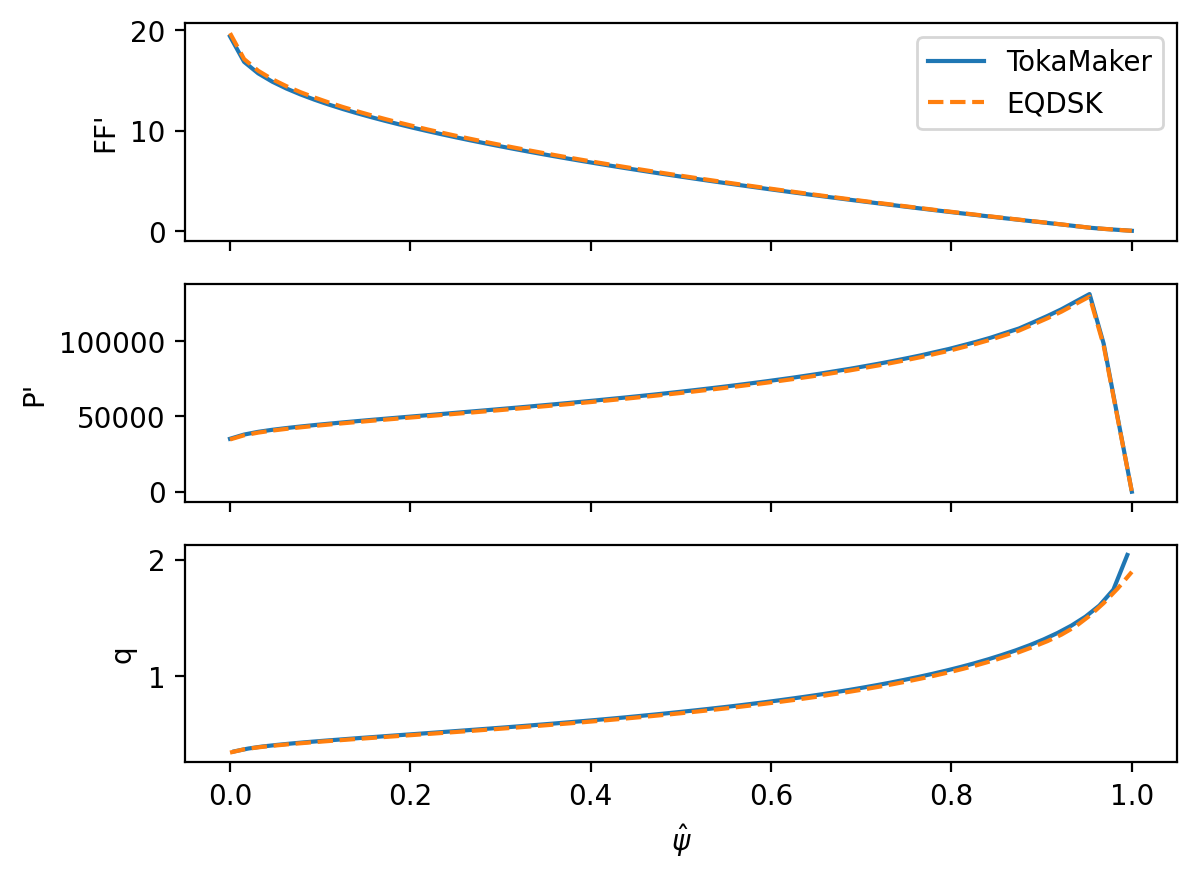

In [14]:
psi,f,fp,p,pp = mygs.get_profiles(npsi=np.size(ffprim))
psi_q,qvals,ravgs,dl,rbounds,zbounds = mygs.get_q(psi_pad=0.005,npsi=np.size(ffprim))
fig, ax = plt.subplots(3,1,sharex=True)
psi_eqdsk = np.linspace(0.0,1.0,eqdsk['nr'])
psi_sample = np.linspace(0.025,1.0,10)
# Plot F*F'
ax[0].plot(psi,f*fp,label='TokaMaker')
ax[0].plot(psi_eqdsk,eqdsk['ffprim'],'--',label='EQDSK')
ax[0].set_ylabel("FF'")
ax[0].legend()
# Plot P'
ax[1].plot(psi,pp)
ax[1].plot(psi_eqdsk,eqdsk['pprime'],'--')
ax[1].set_ylabel("P'")
# Plot q
ax[2].plot(psi_q,qvals)
ax[2].plot(psi_eqdsk,eqdsk['qpsi'],'--')
ax[2].set_ylabel("q")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

In [15]:
tMaker_currs, _ = mygs.get_coil_currents()
# imap = [0,1,2,3,10,4,9,5,8,6,7,11,12]
for key, coil_set in mygs.coil_sets.items():
    if key.startswith('VV'):
        break
    i = coil_set['id']
    if i < len(imap) and imap[i] >= 0:
        print('{2} {0:.3E} {1:.3E}'.format(tMaker_currs[i],coil_currs[imap[i]]*1000.0,key))
    else:
        print('{1} {0:.3E}'.format(tMaker_currs[i],key))

CS_1 -6.832E+06 -6.831E+06
CS_2 -9.380E+06 -9.383E+06
CS_3 -6.123E+06 -6.121E+06
PF_1U -5.313E+05 -5.273E+05
PF_1L -1.351E+06 -1.346E+06
PF_2U -1.711E+06 -1.708E+06
PF_2L -7.845E+05 -7.816E+05
PF_3U 8.297E+05 8.307E+05
PF_3L 2.613E+05 2.622E+05
PF_4U -1.477E+06 -1.481E+06
PF_4L -1.240E+06 -1.244E+06
DIV_1U -1.318E-06
DIV_1L -1.004E-06
DIV_2U -7.036E+02 -6.128E+01
DIV_2L -1.431E+03 1.288E+01
